Author: Fuad

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score

from xgboost import XGBClassifier


In [2]:
# Load train & test sets
train_df = pd.read_csv("kdd_train.csv")
test_df = pd.read_csv("kdd_test.csv")

train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [3]:
label_col = "labels"

# Split train
X_train = train_df.drop(columns=[label_col])
y_train = train_df[label_col]

# Filter test to only classes seen in training
test_df = test_df[test_df[label_col].isin(train_df[label_col])]

X_test = test_df.drop(columns=[label_col])
y_test = test_df[label_col]


In [4]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)  # safe now, no unseen labels

In [5]:
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()


In [6]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])


In [7]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softmax",
    num_class=len(label_encoder.classes_),
    eval_metric="mlogloss",
    n_jobs=-1,
    random_state=42
)


In [8]:
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', xgb_model)
])


In [9]:
# Fit the pipeline on numeric labels
pipeline.fit(X_train, y_train_enc)

# Predict (numeric labels)
y_pred_enc = pipeline.predict(X_test)

# Classification report (use encoded labels)
print(classification_report(y_test_enc, y_pred_enc))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       227
           1       1.00      0.41      0.58        17
           2       0.50      0.50      0.50         2
           3       1.00      0.02      0.04       411
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00       479
           6       1.00      0.50      0.67         2
           7       1.00      0.75      0.86         4
           8       1.00      0.11      0.20         9
           9       1.00      1.00      1.00      6654
          10       1.00      1.00      1.00       206
          11       0.94      0.99      0.97     11245
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       0.87      0.97      0.92        35
          15       0.97      1.00      0.98       371
          16       1.00      0.25      0.40         4
          17       0.93    

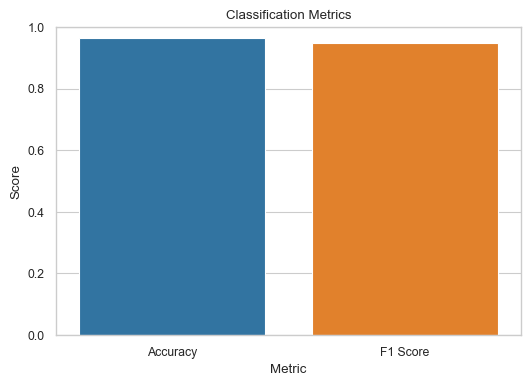

In [10]:
# Apply style
sns.set_style("whitegrid")
sns.set_context("paper")

# Compute metrics using encoded labels
accuracy = accuracy_score(y_test_enc, y_pred_enc)
f1 = f1_score(y_test_enc, y_pred_enc, average='weighted')  # weighted F1 for multiclass

# Prepare DataFrame for plotting
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score'],
    'Value': [accuracy, f1]
})

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Metric', y='Value', data=metrics_df)
plt.title("Classification Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()
